In [1]:
#Блок в рамках которого импотряться математические подсчеты, падас и нампай
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats


import os

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder

### 0. Предварительный EDA

In [2]:
# making "directoryback"
os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [3]:
data = pd.read_csv('Data/PhonesDF_years.csv')
data.sample(3)

,phone_title,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,battery_type,disp_height,disp_width,oper_syst_type,oper_syst_vers,brand,year_of_release
415,HTC 10 64 GB,14979.0,3.0,56,3,5.2,5.0,64.0,4.0,3000.0,Li-Ion,2560.0,1440.0,Android,6,HTC,2016
872,Sony Xperia XZs 32GB,46000.0,4.0,56,3,5.2,13.0,32.0,4.0,2900.0,Li-Ion,1920.0,1080.0,Android,7,Sony,2017
552,Samsung Galaxy J6 Plus 32GB SM-J610F/DS,599.0,3.3,45,38,6.0,8.0,32.0,3.0,3300.0,Li-Ion,1480.0,720.0,Android,8,Samsung,2018


In [4]:
# adding log price and PPI to dataset
data['log_price'] = np.log(data.price)
data['density'] = data.disp_height * data.disp_width / data.disp_diag

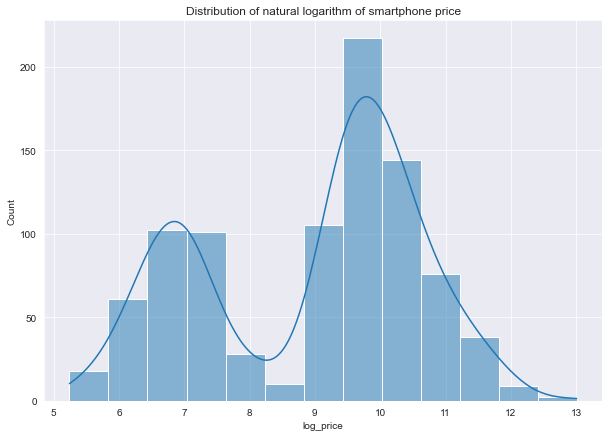

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что у нас получилось бимодальное распределение, где каждый колокол напомоминает нормальное распределение. Скорее всего, это связано с тем, что у нас в датасете есть много некорректно указанных цен (ошибка с порядком цены), так как в левой части распределения телефоны имеют цену ниже 2000 рублей, что выглядит неправдоподобно.

Избавимся от этих выбросов и построим новое распределение цены:

In [6]:
# correcting and saving data
data = data.loc[(data.price >= np.exp(8.3)) & (data.price < np.exp(12.5)), :].copy(deep=True)
data.to_csv('Data/PhonesDF_years_corrected.csv', index=False)

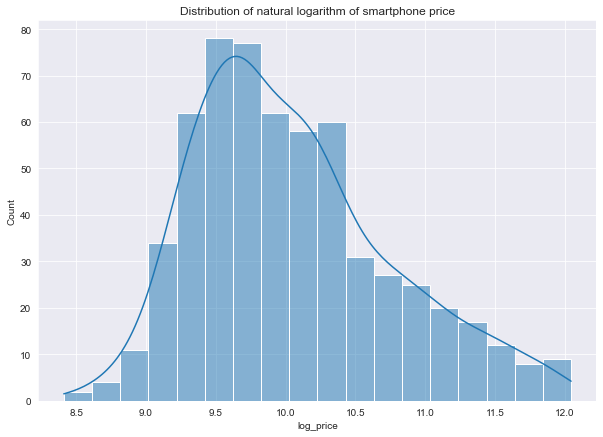

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что распределение логарифма цены имеет правостороннюю ассиметрию.

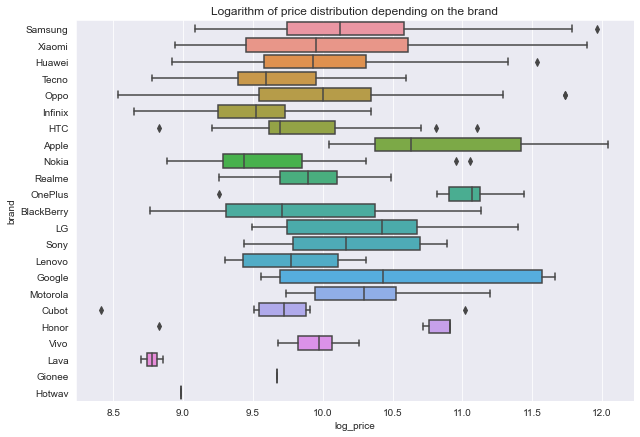

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=data, y='brand', x='log_price', ax=ax, order=list(data.brand.value_counts().index))
ax.set_title('Logarithm of price distribution depending on the brand');

Видно, что айфоны и смартфоны бренда Google сущестсвенно дороже, чем остальные.

Построим, как цена и ее логарифм зависит от числовых характеристик смартфона.

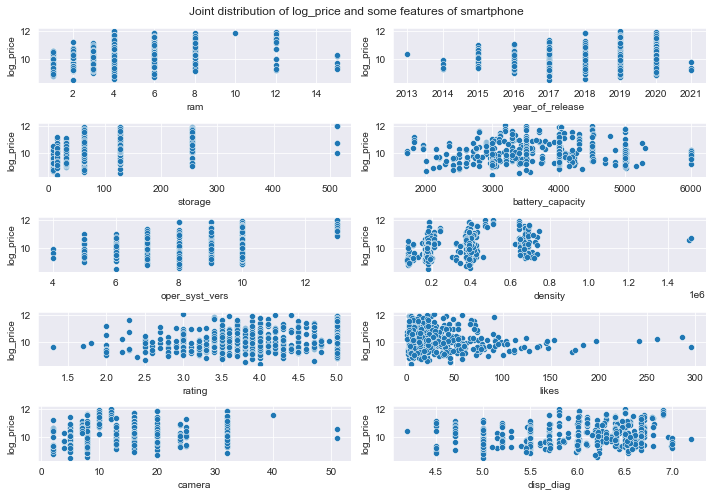

In [16]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='log_price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of log_price and some features of smartphone')
plt.tight_layout();

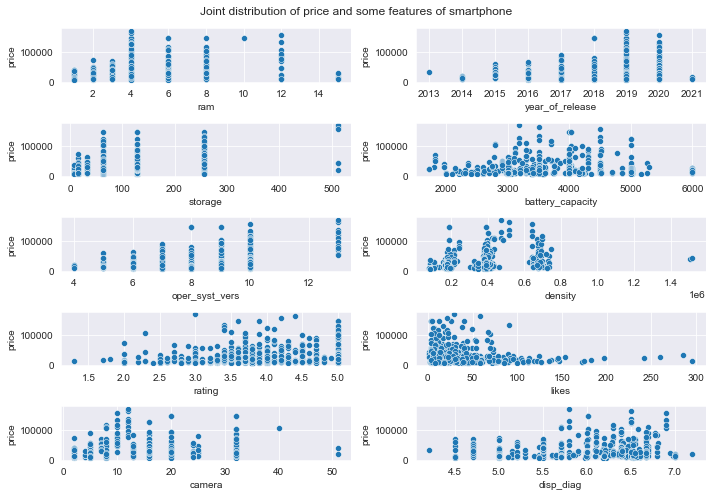

In [14]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of price and some features of smartphone')
plt.tight_layout();

Таким образом, явной линейной и логлинейной звисимости тут не прослеживается. Попробуем отлогарифмировать признаки.

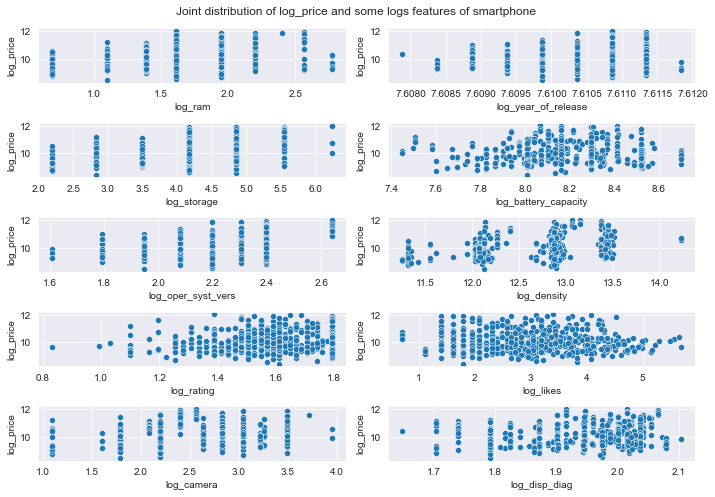

In [20]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.log_price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('log_price')
fig.suptitle('Joint distribution of log_price and some logs features of smartphone')
plt.tight_layout();

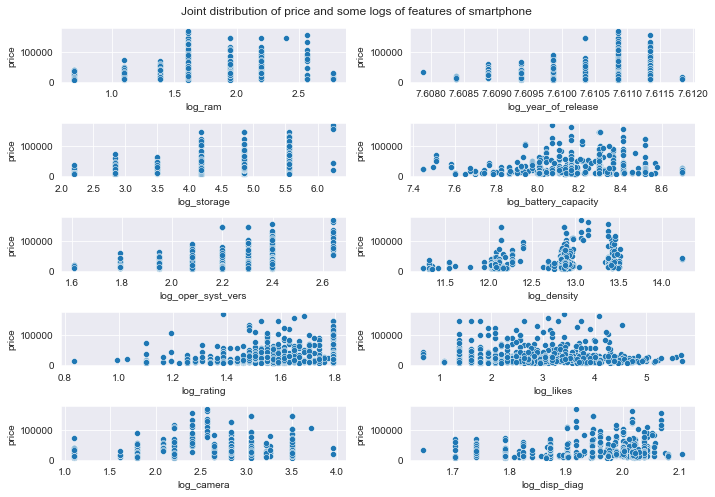

In [21]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('price')
fig.suptitle('Joint distribution of price and some logs of features of smartphone')
plt.tight_layout();

Явных зависимостей тоже не видно, но это всего лишь проекция данных на 2 оси, так что не стоит отчаиваться!

Посмотрим на корреляции 

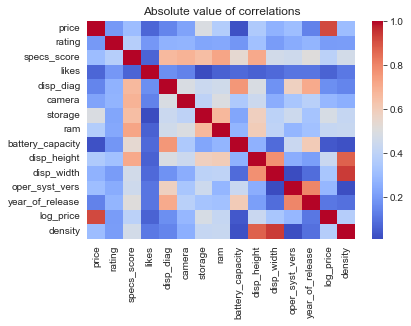

In [30]:
sns.heatmap(np.abs(data.corr()), cmap="coolwarm")
plt.title('Absolute value of correlations');

### 1. Подготовка данных для регрессии

In [23]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(columns = [feature_to_encode])
    return(res)

In [24]:
data['Other_oper_syst'] = 0
data['IOS_oper_syst'] = 0

data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
data = data.drop(columns = ['oper_syst_type'])

In [25]:
data = encode_and_bind(data, 'battery_type')
data = encode_and_bind(data, 'brand')

In [26]:
data.sample(3)

,phone_title,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
181,Nokia 6.1 64GB,63099.0,3.8,62,37,5.50,8.0,64.0,4.0,3000.0,...,0,1,0,0,0,0,0,0,0,0
177,Nokia 1 Plus 8GB,16999.0,5.0,33,6,5.45,5.0,8.0,1.0,2500.0,...,0,1,0,0,0,0,0,0,0,0
256,Oppo Reno 4 Pro 4G 8GB/256GB,699.0,4.0,100,15,6.50,32.0,256.0,8.0,4000.0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
data = data.set_index('phone_title')

In [28]:
data

,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
phone_title,,,,,,,,,,,,,,,,,,,,,
Gionee M7 Power,15880.0,4.0,56,13,6.00,8.0,64.0,4.0,4000.0,1440.0,...,0,0,0,0,0,0,0,0,0,0
Gionee M7,15880.0,4.5,69,8,6.01,8.0,64.0,6.0,4000.0,2160.0,...,0,0,0,0,0,0,0,0,0,0
Samsung Galaxy M21 6GB/128GB,21590.0,4.3,100,30,6.40,20.0,128.0,6.0,6000.0,2340.0,...,0,0,0,0,0,1,0,0,0,0
Samsung Galaxy M21 4GB/64GB,22499.0,3.8,94,31,6.40,20.0,64.0,4.0,6000.0,2340.0,...,0,0,0,0,0,1,0,0,0,0
Samsung Galaxy A31 6GB/128GB,24999.0,3.8,98,31,6.40,20.0,128.0,6.0,5000.0,2400.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nokia 3.1 3GB/32GB,10600.0,4.5,51,41,5.20,8.0,32.0,3.0,2990.0,1440.0,...,0,1,0,0,0,0,0,0,0,0
Nokia 7.2 6GB/128GB,29999.0,4.1,93,69,6.30,20.0,128.0,6.0,3500.0,2280.0,...,0,1,0,0,0,0,0,0,0,0
Nokia 7.2 4GB/64GB,26000.0,3.7,86,23,6.30,20.0,64.0,4.0,3500.0,2280.0,...,0,1,0,0,0,0,0,0,0,0


### 2. EDA

In [29]:
np.round(data.describe(), 2)

,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,disp_height,...,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo,brand_Xiaomi
count,911.00,911.00,911.00,911.00,911.00,911.00,911.00,911.00,911.00,911.00,...,911.00,911.00,911.00,911.00,911.00,911.00,911.00,911.00,911.00,911.00
mean,21438.29,3.90,67.43,26.83,5.99,13.58,84.20,4.53,3769.36,1975.60,...,0.02,0.04,0.03,0.08,0.05,0.18,0.02,0.07,0.01,0.13
std,33241.35,0.74,21.02,33.60,0.59,8.97,79.04,2.56,858.04,527.58,...,0.13,0.19,0.16,0.26,0.21,0.38,0.14,0.26,0.07,0.33
min,189.00,1.30,26.00,1.00,4.00,2.00,8.00,1.00,1560.00,480.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1221.00,3.40,52.00,8.00,5.50,8.00,32.00,3.00,3020.00,1548.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,13500.00,3.90,62.00,16.00,6.20,10.00,64.00,4.00,4000.00,1920.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25499.50,4.50,90.00,31.00,6.50,16.00,128.00,6.00,4200.00,2340.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,446342.00,5.00,100.00,296.00,7.20,51.00,512.00,15.00,7000.00,3840.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [30]:
def mean_mode_median(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Function for finding mean median and mode of continious data
    '''
    df = pd.DataFrame()
    df['Mode'] = stats.mode(dataframe)[0][0]
    df['Median'] = np.median(dataframe, axis=0)
    df['Mean'] = np.mean(dataframe, axis=0).to_numpy()
    
    df = np.round(df, 2)
    
    df.index = dataframe.columns
    return df

In [31]:
mean_mode_median(data)

,Mode,Median,Mean
price,1150.0,13500.0,21438.29
rating,5.0,3.9,3.90
specs_score,100.0,62.0,67.43
likes,6.0,16.0,26.83
disp_diag,5.5,6.2,5.99
camera,8.0,10.0,13.58
storage,128.0,64.0,84.20
ram,4.0,4.0,4.53
battery_capacity,4000.0,4000.0,3769.36
disp_height,2340.0,1920.0,1975.60


### 3. Multicollinearity

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data = add_constant(data)
pd.Series([variance_inflation_factor(data.values, i) 
               for i in range(data.shape[1])], 
              index=data.columns)


C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                  0.000000
price                  1.228503
rating                 1.334309
specs_score            7.382856
likes                  1.475786
disp_diag              6.067067
camera                 2.278028
storage                2.787005
ram                    2.787569
battery_capacity       3.631527
disp_height            7.231899
disp_width             4.388191
oper_syst_vers         3.850988
Other_oper_syst        1.214405
IOS_oper_syst               inf
battery_type_ Li-Po    1.931686
brand_BlackBerry            inf
brand_Cubot                 inf
brand_Gionee                inf
brand_Google                inf
brand_HTC                   inf
brand_Honor                 inf
brand_Hotwav                inf
brand_Huawei                inf
brand_Infinix               inf
brand_LG                    inf
brand_Lava                  inf
brand_Lenovo                inf
brand_Motorola              inf
brand_Nokia                 inf
brand_OnePlus               inf
brand_Op

In [135]:
np.linalg.det(np.array(data)@np.array(data).T)

0.0

In [136]:
data = data.drop(columns = 'IOS_oper_syst')

In [137]:
pd.Series([variance_inflation_factor(data.values, i) 
               for i in range(data.shape[1])], 
              index=data.columns)


const                  288.720211
price                    1.228503
rating                   1.334309
specs_score              7.382856
likes                    1.475786
disp_diag                6.067067
camera                   2.278028
storage                  2.787005
ram                      2.787569
battery_capacity         3.631527
disp_height              7.231899
disp_width               4.388191
oper_syst_vers           3.850988
Other_oper_syst          1.214405
battery_type_ Li-Po      1.931686
brand_BlackBerry         2.188008
brand_Cubot              1.499425
brand_Gionee             1.193710
brand_Google             1.819005
brand_HTC                3.456522
brand_Honor              1.748016
brand_Hotwav             1.240288
brand_Huawei             9.077925
brand_Infinix            5.229391
brand_LG                 3.064980
brand_Lava               1.104855
brand_Lenovo             2.699044
brand_Motorola           1.988620
brand_Nokia              2.997077
brand_OnePlus 

In [138]:
np.linalg.det(np.array(data)@np.array(data).T)

0.0

In [139]:
data['density'] = data['disp_height']*data['disp_width']/data['disp_diag']
data = data.drop(columns = ['disp_height', 'disp_width', 'specs_score'])


In [140]:
pd.Series([variance_inflation_factor(data.values, i) 
               for i in range(data.shape[1])], 
              index=data.columns)


const                  249.191601
price                    1.221523
rating                   1.314134
likes                    1.466582
disp_diag                5.268783
camera                   1.778790
storage                  2.511405
ram                      2.543939
battery_capacity         3.401183
oper_syst_vers           3.686148
Other_oper_syst          1.204938
battery_type_ Li-Po      1.875563
brand_BlackBerry         2.129843
brand_Cubot              1.479180
brand_Gionee             1.185886
brand_Google             1.797135
brand_HTC                3.354276
brand_Honor              1.679434
brand_Hotwav             1.218606
brand_Huawei             8.616518
brand_Infinix            5.058995
brand_LG                 3.016137
brand_Lava               1.096424
brand_Lenovo             2.646448
brand_Motorola           1.944055
brand_Nokia              2.897226
brand_OnePlus            2.692016
brand_Oppo               5.504384
brand_Realme             4.042659
brand_Samsung 